# Handwritten Digits - MNIST GAN With Seed Experiments

Make Your First GAN With PyTorch, 2020

In [ ]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [1]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

## Dataset Class

In [91]:
# dataset class

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file)        
        # self.data_df = pandas.read_csv(csv_file, header=None)        
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
        
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        img = img.astype(float)
        plt.figure(figsize=(5,5))
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    def plot_image_from_data(self, image_data):
        plt.figure(figsize=(5,5))
        plt.title("Generated Image")
        plt.imshow(image_data, interpolation='none', cmap='Blues')
        pass
    
    pass

In [136]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [92]:
# load data

# mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

mnist_dataset = MnistDataset('./mnist_train.csv')

In [83]:
# target = torch.zeros((10))
# print(target.shape)
# target[1] = 1.0
# print(target)

# df = pandas.read_csv('./mnist_train.csv')

# print(df)

mnist_dataset[0]

print(len(mnist_dataset.data_df))

# 

# label = mnist_dataset.data_df.iloc[0, 0]

# print(mnist_dataset.data_df.iloc[0])


5
60000


In [56]:
# for label, image_values, target in mnist_dataset:
#     print(label)
#     # print(image_values.shape)
#     # print(target)
#     break

# print(len(mnist_dataset))

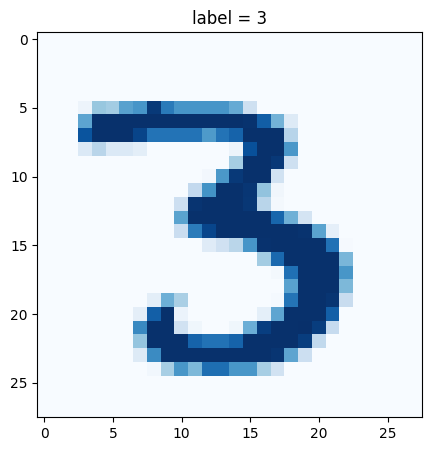

In [85]:
# check data contains images

mnist_dataset.plot_image(12)

## Data Functions

In [86]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

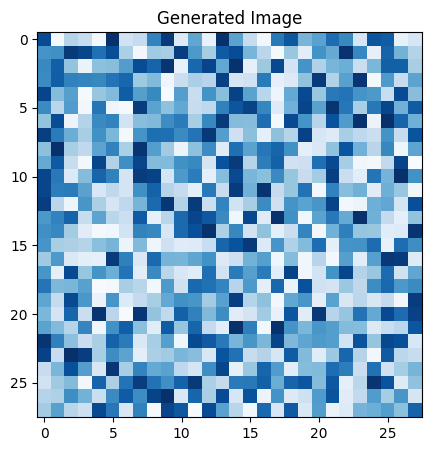

In [87]:
random_image = generate_random_image(784).reshape(28, 28)

mnist_dataset.plot_image_from_data(random_image)


## Discriminator Network

In [134]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self, device):
        self.device = device
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        ).to(self.device)
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs.to(self.device))
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        inputs = inputs.to(self.device)
        targets = targets.to(self.device)

        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## Test Discriminator

In [137]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator(device)

for i in range(len(mnist_dataset.data_df)):
        
    label, image_data_tensor, target_tensor = mnist_dataset[i]
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image(784), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 42s, sys: 4.55 s, total: 4min 47s
Wall time: 4min 54s


In [94]:
mnist_dataset

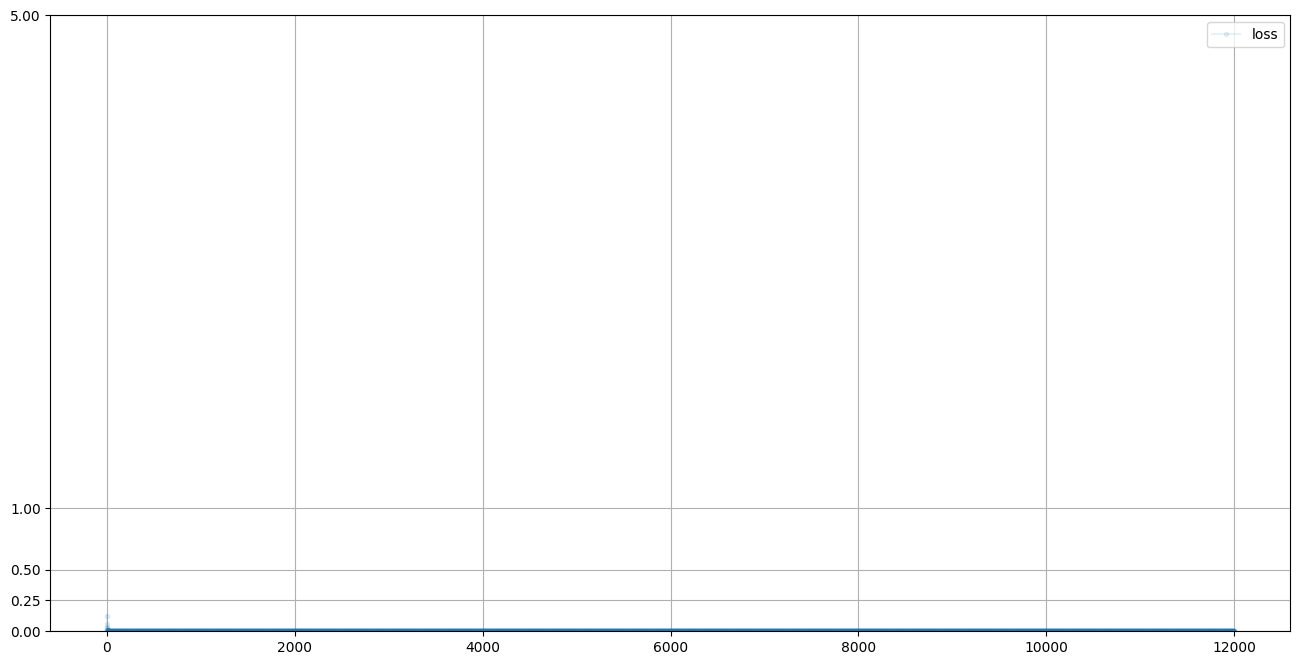

In [95]:
# plot discriminator loss

D.plot_progress()

In [96]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(784) ).item() )
  pass

1.0
1.0
1.0
1.0
8.977169702051313e-12
1.0352010047787186e-11
1.053956748264806e-11
9.231482765714727e-12


## Generator Network

In [138]:
# generator class

class Generator(nn.Module):
    
    def __init__(self, device):
        # initialise parent pytorch class
        super().__init__()
        self.device = device
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        ).to(self.device)
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs.to(self.device))
    
    
    def train(self, D, inputs, targets):
        inputs = inputs.to(self.device)
        targets = targets.to(self.device)

        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## Test Generator Output

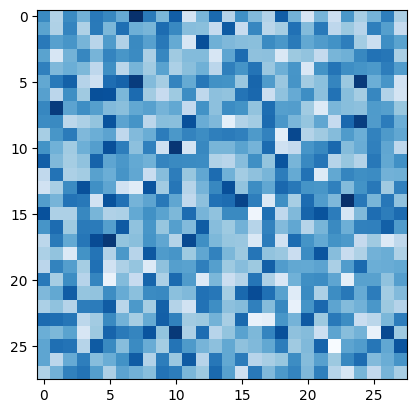

In [144]:
# check the generator output is of the right type and shape

G = Generator(device)

output = G.forward(generate_random_seed(100))

if device == "cuda":
    output = list(map(lambda x: x.cpu(), output))

# print(device)
img = output.detach().cpu().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

## Train GAN

In [147]:
%%time 

# create Discriminator and Generator

D = Discriminator(device)
G = Generator(device)

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  # for label, image_data_tensor, target_tensor in mnist_dataset:

  for i in range(len(mnist_dataset.data_df)):
        
    label, image_data_tensor, target_tensor = mnist_dataset[i]

    # train discriminator on true
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000


KeyboardInterrupt: 

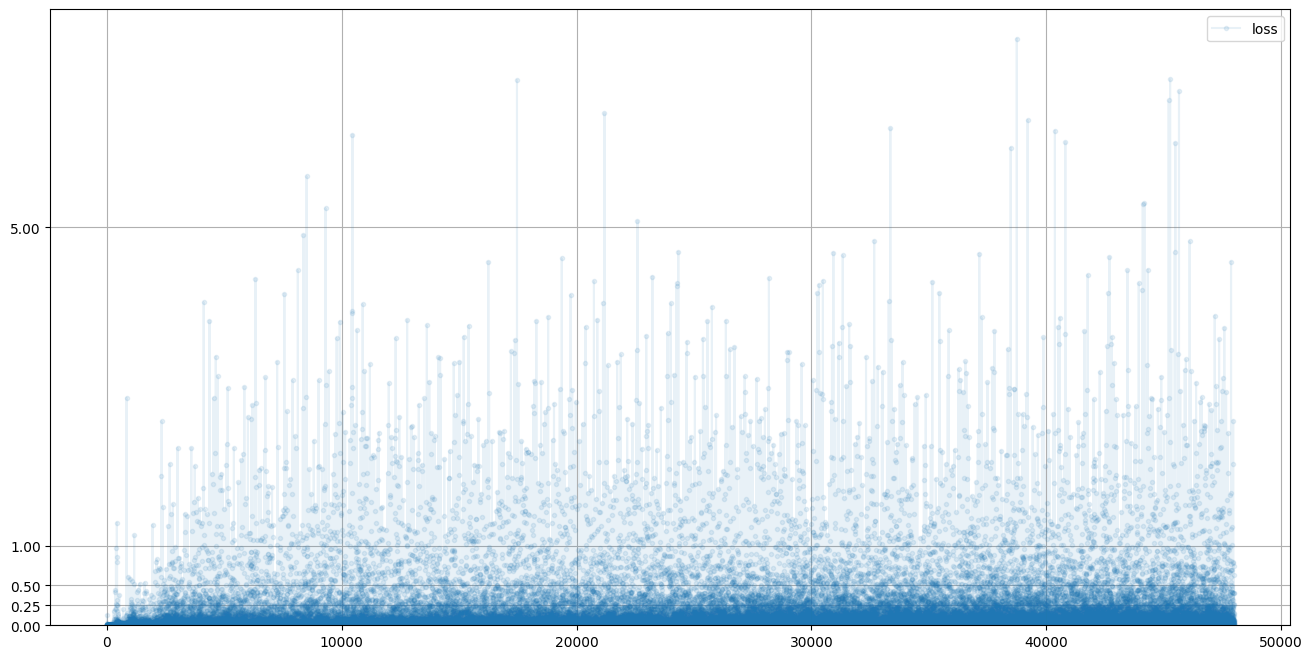

In [101]:
# plot discriminator error

D.plot_progress()

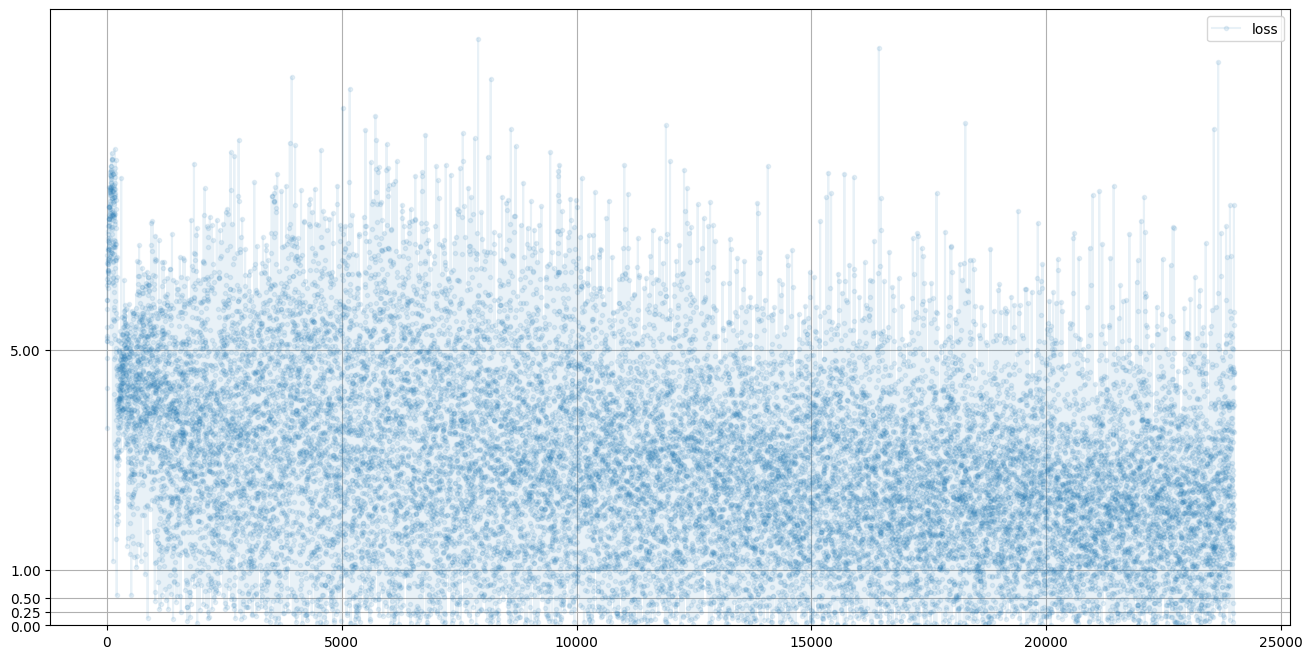

In [102]:
# plot generator error

G.plot_progress()

## Run Generator

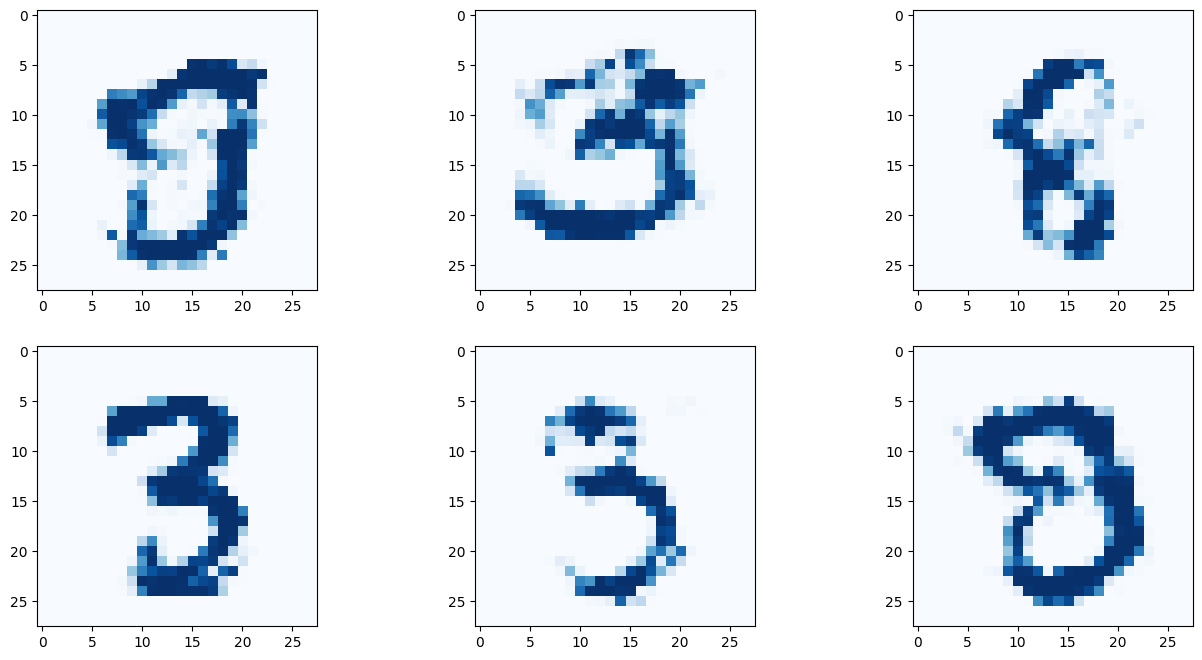

In [103]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

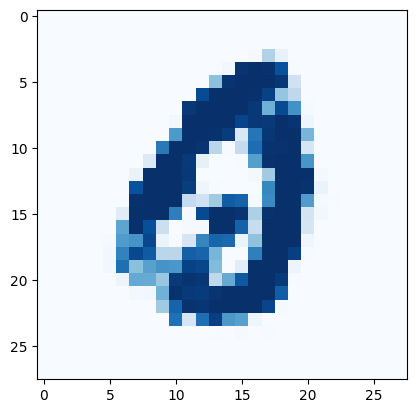

In [104]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')

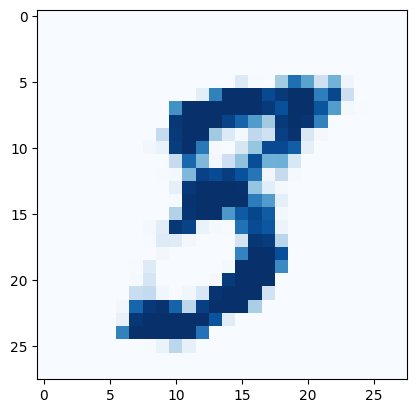

In [133]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

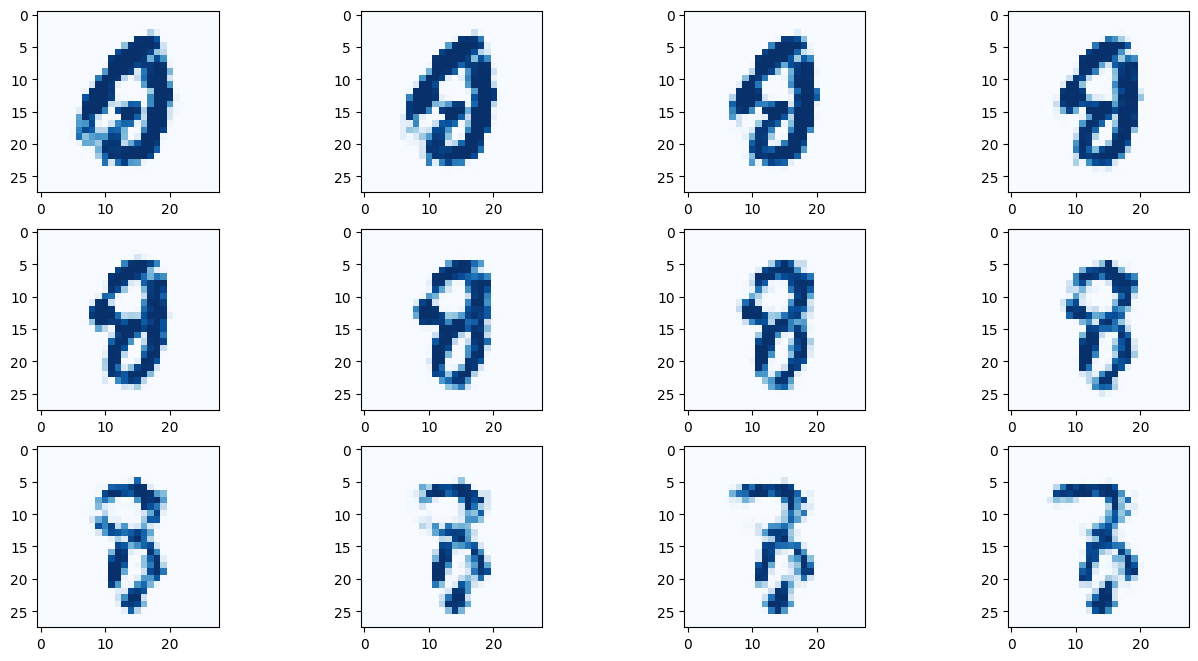

In [106]:
# plot several outputs from the trained generator

count = 0

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2 - seed1)/11 * count
        output = G.forward(seed)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1
        pass
    pass

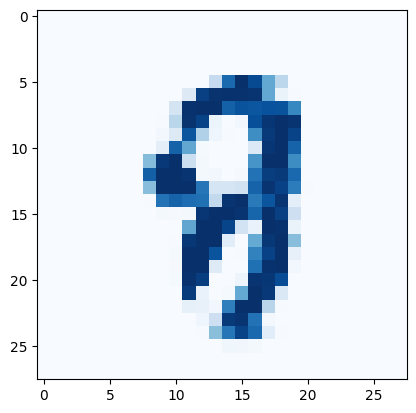

In [111]:
# sum of seeds

seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

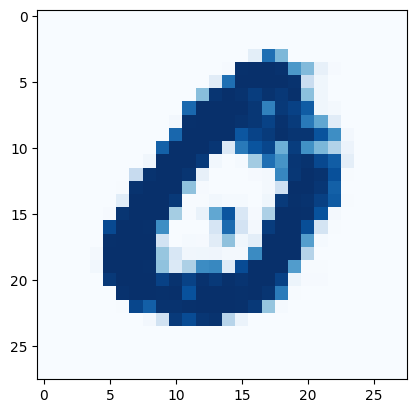

In [112]:
# difference of seeds

seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

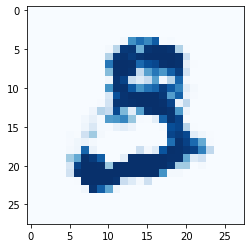

In [ ]:
# difference of seeds

seed4 = seed1 * seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')